<a href="https://colab.research.google.com/github/samiha-mahin/An-Image-Processing-Repo/blob/main/Breast_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"3b6d29c9556db74812f31ee98a90662f"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p ./data --unzip


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 78% 152M/195M [00:00<00:00, 560MB/s] 
100% 195M/195M [00:00<00:00, 492MB/s]


# **Load Dataset into DataFrame**

In [55]:
import numpy as np
import pandas as pd
import os
import cv2

In [56]:
base_path = "./data/Dataset_BUSI_with_GT"

categories = ["benign","malignant","normal"]

data = []

for label in categories:
    folder = os.path.join(base_path, label)
    for file in os.listdir(folder):
      if file.endswith(".png") and "_mask" not in file:
        data.append([os.path.join(folder,file),label])

df = pd.DataFrame(data, columns=["image_path","label"])
print("Dataset Shape:",df.shape)
df.head()

Dataset Shape: (780, 2)


,image_path,label
0,./data/Dataset_BUSI_with_GT/benign/benign (372...,benign
1,./data/Dataset_BUSI_with_GT/benign/benign (75)...,benign
2,./data/Dataset_BUSI_with_GT/benign/benign (306...,benign
3,./data/Dataset_BUSI_with_GT/benign/benign (188...,benign
4,./data/Dataset_BUSI_with_GT/benign/benign (14)...,benign


### Code Explaination:

1. **Set the dataset location** → `base_path`
   (where the images are stored).

2. **Define categories** → `benign`, `malignant`, `normal`.
   (these are the folders inside `base_path`).

3. **Loop through each category**

   * Go inside the folder.
   * Look at all image files (`.png`).
   * Skip files that have `_mask` in their name (because those are segmentation masks, not raw images).

4. **Save info into a list** → each image gets stored with its path and label.

5. **Convert list into a DataFrame (df)** → easy to use later for ML.

6. **Print dataset shape and preview**



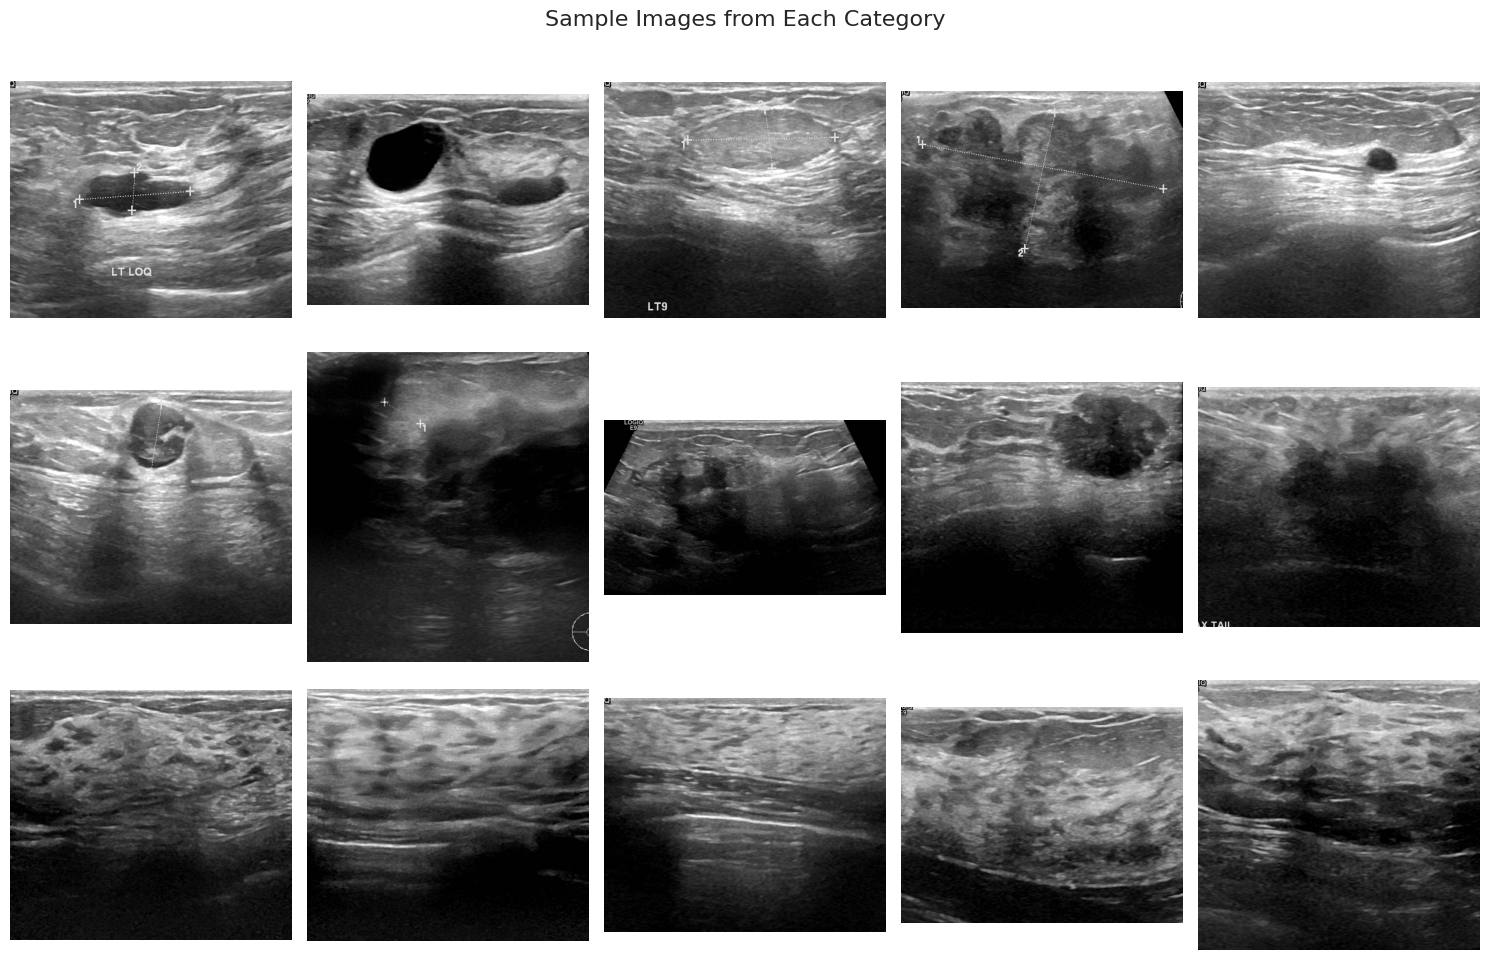

In [57]:
import matplotlib.pyplot as plt
import cv2

num_images = 5  # images per class

# Create the plot grid
fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))
fig.suptitle("Sample Images from Each Category", fontsize=16)

# Loop through each category
for i, category in enumerate(categories):
    images = df[df['label'] == category].sample(num_images, random_state=42)
    for j, path in enumerate(images['image_path']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)      # Show image
        axes[i, j].axis('off')      # Remove axes
    axes[i, 0].set_ylabel(category, fontsize=14)  # Label only first column

plt.tight_layout()
plt.show()


#**Visualize Data Distribution**

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-3309689242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df ,palette='pastel')


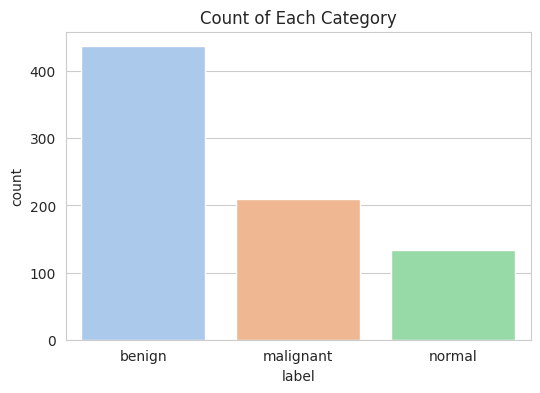

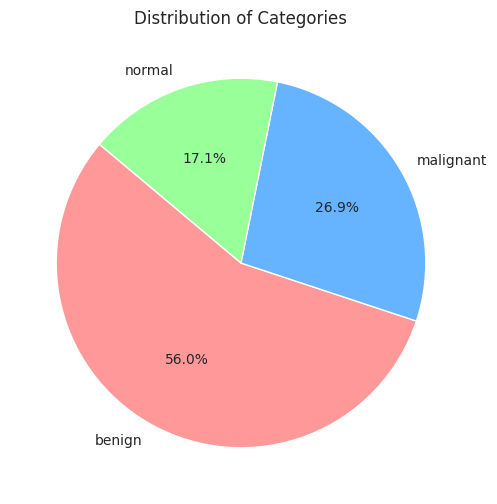

In [59]:
# Bar chart of categories
plt.figure(figsize=(6, 4))
sns.countplot(x="label", data=df ,palette='pastel')
plt.title("Count of Each Category")
plt.show()

# Pie chart of categories
df["label"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", startangle=140, figsize=(6, 6),colors=['#ff9999','#66b3ff','#99ff99']
)
plt.title("Distribution of Categories")
plt.ylabel("")  # removes y-axis label
plt.show()


# **Encode Labels & Balance Dataset**

In [32]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

In [53]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Encode labels into numbers
encoder = LabelEncoder()
df["category_encoded"] = encoder.fit_transform(df["label"])

# Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(df[["image_path"]], df["category_encoded"])

# Create the new balanced DataFrame
df_resampled = pd.DataFrame({"image_path": X["image_path"], "category_encoded": y})

print("\nBalanced class counts:")
print(df_resampled["category_encoded"].value_counts())


Balanced class counts:
category_encoded
0    437
1    437
2    437
Name: count, dtype: int64


# **Train/Valid/Test Split**

In [34]:
from sklearn.model_selection import train_test_split

In [40]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str) #the category 1, 2, 3 will become string like "1","2","3"

train_df, temp_df = train_test_split(df_resampled, train_size=0.8, shuffle=True,
                                     stratify=df_resampled['category_encoded'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True,
                                     stratify=temp_df['category_encoded'], random_state=42)

print("Train size:", train_df.shape)
print("Validation size:", valid_df.shape)
print("Test size:", test_df.shape)

Train size: (1048, 2)
Validation size: (131, 2)
Test size: (132, 2)


# **Data Generators**

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col='category_encoded',
                                       target_size=img_size, class_mode='sparse',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image_path', y_col='category_encoded',
                                       target_size=img_size, class_mode='sparse',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image_path', y_col='category_encoded',
                                      target_size=img_size, class_mode='sparse',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 1048 validated image filenames belonging to 3 classes.
Found 131 validated image filenames belonging to 3 classes.
Found 132 validated image filenames belonging to 3 classes.


# **Build Transfer Learning Model (VGG16 + Attention)**

In [60]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, MultiHeadAttention
from tensorflow.keras.optimizers import Adam

def create_model(input_shape=(224, 224, 3), num_classes=3):
    # Input
    inputs = Input(shape=input_shape)

    # Pretrained VGG16 (without top layers)
    base = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Freeze all layers except last 4
    for layer in base.layers[:-4]:
        layer.trainable = False

    x = base.output

    # Add attention and noise
    x = MultiHeadAttention(num_heads=8, key_dim=x.shape[-1])(x, x)
    x = GaussianNoise(0.25)(x)

    # Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Create model
model = create_model()

# Compile model
model.compile(optimizer=Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_5[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 23,512,899 (89.69 MB)

 Trainable params: 15,876,611 (60.56 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

### **VGG16-based model explanation**

| Step | Code / Layer                                   | What It Does                                                | Purpose                                                |
| ---- | ---------------------------------------------- | ----------------------------------------------------------- | ------------------------------------------------------ |
| 1    | `Input(shape=(224,224,3))`                     | Takes image input                                           | Sets input size for the model                          |
| 2    | `VGG16(weights='imagenet', include_top=False)` | Pretrained VGG16 without top layers                         | Uses learned features from ImageNet                    |
| 3    | `layer.trainable = False` (for most layers)    | Freeze most layers                                          | Prevents unnecessary changes; only last 4 layers train |
| 4    | `MultiHeadAttention` + `GaussianNoise`         | Attention focuses on important parts; noise adds randomness | Helps the model focus and generalize                   |
| 5    | `GlobalAveragePooling2D`                       | Converts 3D feature maps to 1D vector                       | Prepares features for dense layers                     |
| 6    | `Dense + BatchNorm + Dropout`                  | Fully connected layers with normalization and dropout       | Learn patterns and prevent overfitting                 |
| 7    | `Dense(3, activation='softmax')`               | Output layer                                                | Predicts 3 classes with probabilities                  |
| 8    | `model.compile(...)`                           | Sets optimizer, loss, metrics                               | Prepares model for training                            |
| 9    | `model.summary()`                              | Shows layer details                                         | Visualize model structure                              |


# **Train Model**

In [50]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=5,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 970s 15s/step - accuracy: 0.9003 - loss: 0.2980 - val_accuracy: 0.6947 - val_loss: 0.6711
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 966s 15s/step - accuracy: 0.9165 - loss: 0.2463 - val_accuracy: 0.7710 - val_loss: 0.5567
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 1008s 15s/step - accuracy: 0.9660 - loss: 0.1090 - val_accuracy: 0.9313 - val_loss: 0.2199
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 931s 14s/step - accuracy: 0.9621 - loss: 0.1365 - val_accuracy: 0.8626 - val_loss: 0.4591
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 953s 14s/step - accuracy: 0.9682 - loss: 0.1230 - val_accuracy: 0.8779 - val_loss: 0.3822


# **Plot Accuracy & Loss**

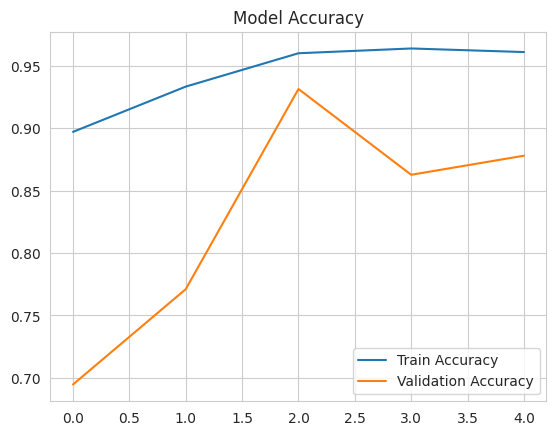

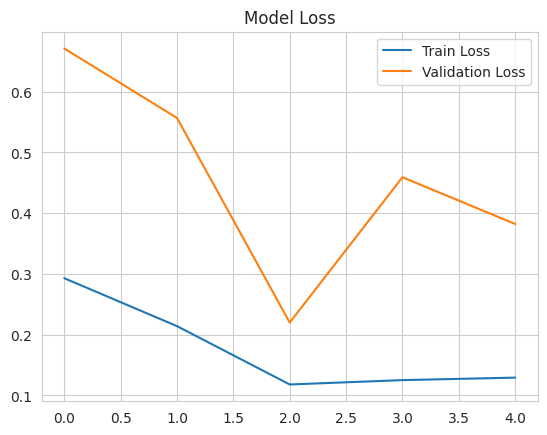

In [51]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()

# **Evaluate on Test Set**

9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 9s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85        44
           1       0.91      0.89      0.90        44
           2       1.00      0.84      0.91        44

    accuracy                           0.89       132
   macro avg       0.90      0.89      0.89       132
weighted avg       0.90      0.89      0.89       132



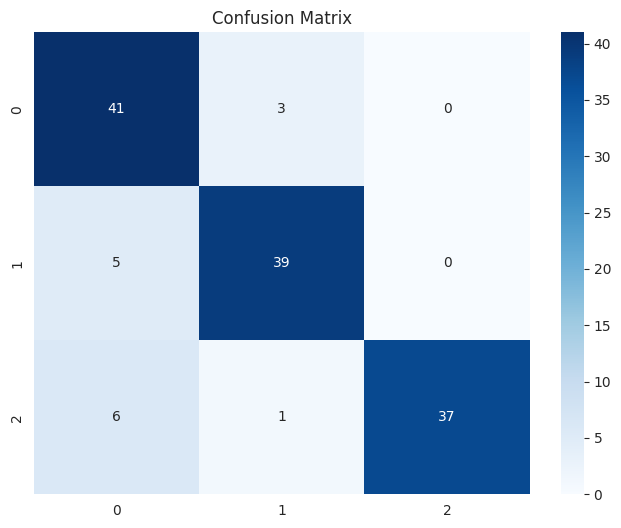

In [52]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True labels from test generator
y_true = test_gen.classes

# Predictions
y_pred = np.argmax(model.predict(test_gen), axis=1) #argmax finds the index of the largest value in an array

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()
